In [1]:
import os
import tensorflow as tf
import tensorflow.keras as K
import numpy as np
import pandas as pd
import math
from PIL import Image
import sys
import random
from matplotlib import pyplot as plt

In [2]:
# !pip3 install pandas

In [3]:
tf.__version__
# tf.keras.mixed_precision.set_global_policy('mixed_float16')

'2.6.0-dev20210425'

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=6500)])
  except RuntimeError as e:
    print(e)

In [6]:
from utils import movie_images_to_dict

In [7]:
trainning_folder="trainning_images"
test_folder="test"

In [8]:
number_of_trainning_videos=len(os.listdir(f'{trainning_folder}'))
number_of_test_videos=1

In [9]:
os.listdir(f'{trainning_folder}')

['nonprimate_clip_120',
 'nonprimate_clip_187',
 'nonprimate_clip_145',
 'nonprimate_clip_191',
 'nonprimate_clip_197',
 'nonprimate_clip_106',
 'nonprimate_clip_169',
 'nonprimate_clip_143',
 'nonprimate_clip_156',
 'nonprimate_clip_160',
 'nonprimate_clip_174',
 'nonprimate_clip_112',
 'nonprimate_clip_101',
 'nonprimate_clip_161',
 'nonprimate_clip_118',
 'nonprimate_clip_107',
 'nonprimate_clip_172',
 'nonprimate_clip_121',
 'nonprimate_clip_116',
 'nonprimate_clip_139',
 'nonprimate_clip_162',
 'nonprimate_clip_157',
 'nonprimate_clip_124',
 'nonprimate_clip_131',
 'nonprimate_clip_181',
 'nonprimate_clip_144',
 'nonprimate_clip_135',
 'nonprimate_clip_168',
 'nonprimate_clip_179',
 'nonprimate_clip_186',
 'nonprimate_clip_127',
 'nonprimate_clip_111',
 'nonprimate_clip_155',
 'nonprimate_clip_108',
 'nonprimate_clip_146',
 'nonprimate_clip_198',
 'nonprimate_clip_196',
 'nonprimate_clip_176',
 'nonprimate_clip_102',
 'nonprimate_clip_130',
 'nonprimate_clip_125',
 'nonprimate_cli

In [10]:

trainning_data_set=[]
test_data_set=[]
# Loop through trainning images
for index in os.listdir(f'{trainning_folder}'):
#     print(index)
    trainning_data_set.append(pd.DataFrame(movie_images_to_dict.get_images_to_dict(f'{trainning_folder}/{index}/')).to_numpy())
# Loop through test images
for index in range(number_of_test_videos):
    test_data_set.append(pd.DataFrame(movie_images_to_dict.get_images_to_dict(f'{test_folder}/{index}/')).to_numpy())

In [11]:
pd.DataFrame(trainning_data_set[1])

,0,1,2,3
0,00000001.png,trainning_images/nonprimate_clip_187/,1080,1920
1,00000002.png,trainning_images/nonprimate_clip_187/,1080,1920
2,00000003.png,trainning_images/nonprimate_clip_187/,1080,1920
3,00000004.png,trainning_images/nonprimate_clip_187/,1080,1920
4,00000005.png,trainning_images/nonprimate_clip_187/,1080,1920
...,...,...,...,...
128,00000129.png,trainning_images/nonprimate_clip_187/,1080,1920
129,00000130.png,trainning_images/nonprimate_clip_187/,1080,1920
130,00000131.png,trainning_images/nonprimate_clip_187/,1080,1920
131,00000132.png,trainning_images/nonprimate_clip_187/,1080,1920


In [12]:
# Split in to groups
def split_in_groups(dataset,number_of_images=2,step=1):
#     Generate in groups
    dataset_gen=[dataset[i : i + number_of_images] for i in range(0, len(dataset), step) if i+number_of_images<len(dataset)]
#     Return as a numpy group
    return np.array(dataset_gen)


# Trainning groups
trainning_groups=[]
for i in range(number_of_trainning_videos):
    trainning_groups.append(split_in_groups(trainning_data_set[i],6))
trainning_groups=np.concatenate(trainning_groups,axis=0)                            
                            

# Test groups
test_groups=[]
for i in range(number_of_test_videos):
    test_groups.append(split_in_groups(test_data_set[i],6))                
test_groups=np.concatenate(test_groups,axis=0)

In [13]:
input_shape=(int(1080/8),int(1920/8),3)
input_shape

(135, 240, 3)

In [14]:
resize_and_rescale = tf.keras.Sequential([
  K.layers.experimental.preprocessing.Resizing(input_shape[0],input_shape[1], interpolation='nearest'),
  K.layers.experimental.preprocessing.Rescaling(1./255)
])
@tf.function
def resize_image(images,y):
    new_images=[]
    for image in images:
        new_images.append(resize_and_rescale(image))
    # print(new_images)
    return tuple(new_images),y
    
@tf.function
def resize_image2(images,y):
    new_images=tf.image.resize(images,(input_shape[0],input_shape[1]),method='nearest')
    new_images=new_images/255
    # print(new_images)
    return new_images,y
# Gen
# def trainning_group_gen():
#     for trainning_group in trainning_groups:
#         images=[]
#         for record in trainning_group:
#             image=Image.open(record[1]+record[0])
#             image=image.resize((input_shape[1],input_shape[0]))
#             images.append(np.array(image)/255)

#         yield tuple(images),1
#         yield tuple(images[::-1]),0
# @tf.function
def trainning_group_gen2():
    for trainning_group in trainning_groups:
        images=[]
        for record in trainning_group:
            image=Image.open(record[1]+record[0])
            images.append(np.array(image))

        yield tuple(images),1
        yield tuple(images[::-1]),0
        
# def test_group_gen():
#     for test_group in test_groups:
#         images=[]
#         for record in test_group:
#             image=Image.open(record[1]+record[0])
#             image=image.resize((input_shape[1],input_shape[0]))
#             images.append(np.array(image)/255)
#         yield tuple(images),1
#         yield tuple(images[::-1]),0
def test_group_gen2():
    for trainning_group in test_groups:
        images=[]
        for record in trainning_group:
            image=Image.open(record[1]+record[0])
            images.append(np.array(image))

        yield tuple(images),1
        yield tuple(images[::-1]),0

In [57]:
# tensor_trainning_dataset=tf.data.Dataset.from_generator(
#     trainning_group_gen,
#     output_signature=(
#     (tf.TensorSpec(shape=input_shape, dtype=tf.float32),tf.TensorSpec(shape=input_shape, dtype=tf.float32)),
#         tf.TensorSpec(shape=(), dtype=tf.int8)
#     )
# ).batch(20).prefetch(tf.data.AUTOTUNE)


# tensor_trainning_dataset2=tf.data.Dataset.from_generator(
#     trainning_group_gen2,
#     output_signature=(
#     (tf.TensorSpec(shape=(1080,1920,3), dtype=tf.float32),tf.TensorSpec(shape=(1080,1920,3), dtype=tf.float32),tf.TensorSpec(shape=(1080,1920,3), dtype=tf.float32),tf.TensorSpec(shape=(1080,1920,3), dtype=tf.float32),tf.TensorSpec(shape=(1080,1920,3), dtype=tf.float32),tf.TensorSpec(shape=(1080,1920,3), dtype=tf.float32)),
#         tf.TensorSpec(shape=(), dtype=tf.int8)
#     )
# ).map(resize_image, num_parallel_calls=tf.data.AUTOTUNE).batch(20).prefetch(tf.data.AUTOTUNE)

tensor_trainning_dataset2 = tf.data.Dataset.from_generator(
     trainning_group_gen2,
     ((tf.float32, tf.float32,tf.float32, tf.float32,tf.float32, tf.float32),tf.int8),
     (
         (tf.TensorShape([1080, 1920, 3]),tf.TensorShape([1080, 1920, 3]),tf.TensorShape([1080, 1920, 3]),tf.TensorShape([1080, 1920, 3]),tf.TensorShape([1080, 1920, 3]),tf.TensorShape([1080, 1920, 3])
    )
    ,tf.TensorShape([])
    )).map(resize_image, num_parallel_calls=32).cache('cache').batch(20).prefetch(tf.data.AUTOTUNE)

tensor_trainning_dataset3 = tf.data.Dataset.from_generator(
     trainning_group_gen2,
     ((tf.float32, tf.float32,tf.float32, tf.float32,tf.float32, tf.float32),tf.int8),
     (
         (tf.TensorShape([1080, 1920, 3]),tf.TensorShape([1080, 1920, 3]),tf.TensorShape([1080, 1920, 3]),tf.TensorShape([1080, 1920, 3]),tf.TensorShape([1080, 1920, 3]),tf.TensorShape([1080, 1920, 3])
    )
    ,tf.TensorShape([])
    )).map(resize_image, num_parallel_calls=32).cache('cache').batch(1).shuffle(buffer_size=5000).prefetch(tf.data.AUTOTUNE)

tensor_trainning_dataset4 = tf.data.Dataset.from_generator(
     trainning_group_gen2,
     ((tf.float32, tf.float32,tf.float32, tf.float32,tf.float32, tf.float32),tf.int8),
     (
         (tf.TensorShape([1080, 1920, 3]),tf.TensorShape([1080, 1920, 3]),tf.TensorShape([1080, 1920, 3]),tf.TensorShape([1080, 1920, 3]),tf.TensorShape([1080, 1920, 3]),tf.TensorShape([1080, 1920, 3])
    )
    ,tf.TensorShape([])
    )).map(resize_image, num_parallel_calls=32).cache('cache').batch(1).prefetch(tf.data.AUTOTUNE)
# tensor_test_dataset=tf.data.Dataset.from_generator(
#     test_group_gen,
#     output_signature=(
#     (tf.TensorSpec(shape=input_shape, dtype=tf.float32),tf.TensorSpec(shape=input_shape, dtype=tf.float32),tf.TensorSpec(shape=input_shape, dtype=tf.float32),tf.TensorSpec(shape=input_shape, dtype=tf.float32),tf.TensorSpec(shape=input_shape, dtype=tf.float32),tf.TensorSpec(shape=input_shape, dtype=tf.float32)),
#         tf.TensorSpec(shape=(), dtype=tf.int8)
#     )
# ).batch(3).prefetch(tf.data.AUTOTUNE)

In [16]:

# tf.math.reduce_mean(np.array([[1,2,3],[2,3,4]],dtype=np.float32),axis=0)

In [17]:
# for i in tensor_trainning_dataset2:
#     pass

In [18]:

def block(block,num_filters):
    block=K.layers.Conv2D(num_filters,3,padding='same')(block)
    block=K.layers.LeakyReLU()(block)
    block=K.layers.BatchNormalization()(block)
    # block=K.layers.Dropout(.1)(block)
    block=K.layers.MaxPool2D((3,3))(block)
    return block
start=K.layers.Input(shape=input_shape)
block_1=block(start,64)
block_2=block(block_1,128)
block_3=block(block_2,256)
block_4=block(block_3,512)
global_max=K.layers.GlobalMaxPool2D()(block_4)
conv=K.Model(inputs=start,outputs=global_max)


image_1=K.Input(input_shape)
image_2=K.Input(input_shape)
image_3=K.Input(input_shape)
image_4=K.Input(input_shape)
image_5=K.Input(input_shape)
image_6=K.Input(input_shape)

image_1_nn=conv(image_1)
image_2_nn=conv(image_2)
image_3_nn=conv(image_3)
image_4_nn=conv(image_4)
image_5_nn=conv(image_5)
image_6_nn=conv(image_6)

def add(images):
    return images[0]+images[1]+images[2]+images[3]+images[4]+images[5]

lambda_layer=tf.keras.layers.Concatenate()([image_1_nn,image_2_nn,image_3_nn,image_4_nn,image_5_nn,image_6_nn])
fc_1=K.layers.Dense(200)(lambda_layer)
fc_1=K.layers.LeakyReLU()(fc_1)
fc_1=K.layers.Dense(200)(fc_1)
fc_1=K.layers.LeakyReLU()(fc_1)
fc_1=K.layers.Dense(200)(fc_1)
fc_1=K.layers.LeakyReLU()(fc_1)
fc_1=K.layers.Dense(100)(fc_1)
fc_1=K.layers.LeakyReLU()(fc_1)
fc_1=K.layers.Dense(100)(fc_1)
fc_1=K.layers.LeakyReLU()(fc_1)
# fc_1=K.layers.LeakyReLU()(fc_1)
fc_2=K.layers.Dense(2,activation='softmax')(fc_1)
# fc_2=K.layers.Dense(2)(fc_1)
# fc_2=K.layers.Activation('softmax', dtype='float32', name='predictions')(fc_2)
# bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)
model=K.Model(inputs=[image_1,image_2,image_3,image_4,image_5,image_6],outputs=fc_2)


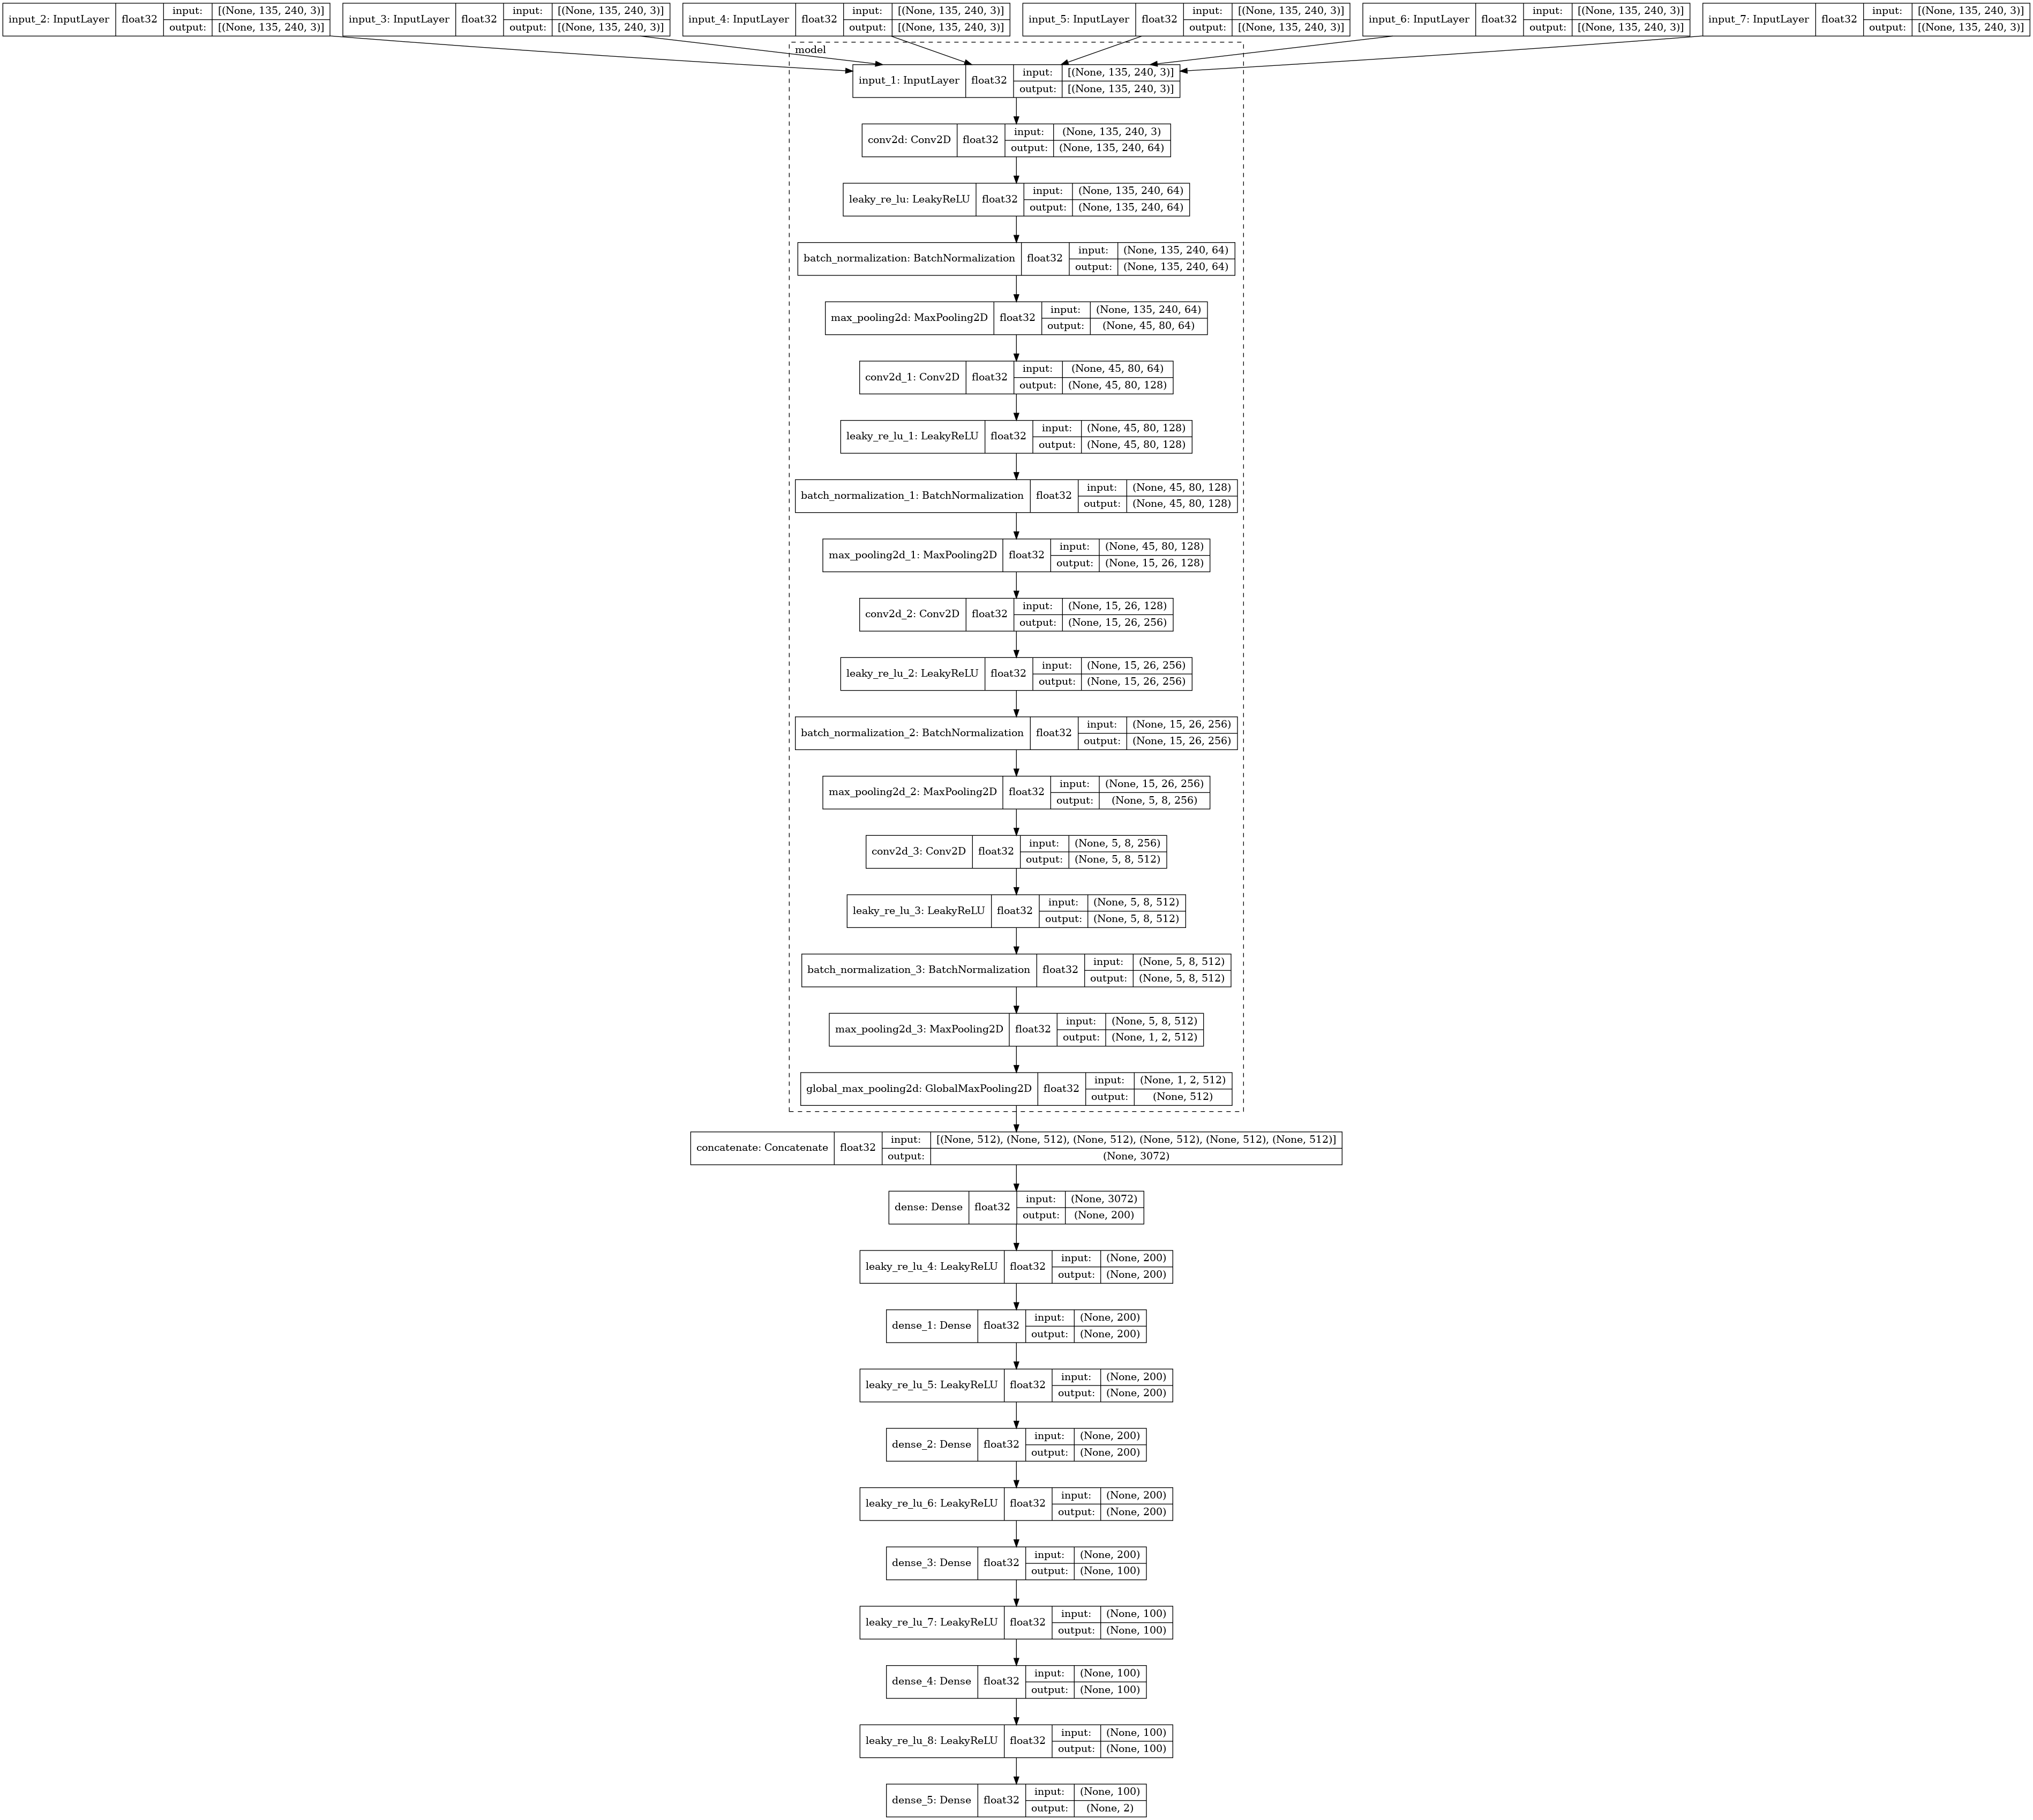

In [19]:
K.utils.plot_model(model,show_shapes=True,expand_nested=True,show_dtype=True)

In [20]:
# run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)
model.compile(
#     options = run_opts,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer=K.optimizers.Adam(learning_rate=0.00005),
    metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.MeanSquaredError(),tf.keras.metrics.SparseCategoricalCrossentropy()]
)

In [21]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 135, 240, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 135, 240, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 135, 240, 3) 0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 135, 240, 3) 0                                            
____________________________________________________________________________________________

In [79]:
# model = tf.keras.models.load_model('back4ards')
model.compile(
#     options = run_opts,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer=K.optimizers.Adam(learning_rate=0.000005),
    metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.MeanSquaredError(),tf.keras.metrics.SparseCategoricalAccuracy()]
)
history=model.fit(tensor_trainning_dataset2,epochs=95)

Epoch 1/95
1157/1157 [==============================] - 126s 108ms/step - loss: 0.0524 - binary_accuracy: 0.5000 - mean_squared_error: 0.4792 - sparse_categorical_accuracy: 0.9749
Epoch 2/95
1157/1157 [==============================] - 125s 108ms/step - loss: 0.0492 - binary_accuracy: 0.5000 - mean_squared_error: 0.4800 - sparse_categorical_accuracy: 0.9754
Epoch 3/95
1157/1157 [==============================] - 125s 108ms/step - loss: 0.0468 - binary_accuracy: 0.5000 - mean_squared_error: 0.4809 - sparse_categorical_accuracy: 0.9771
Epoch 4/95
1157/1157 [==============================] - 125s 108ms/step - loss: 0.0446 - binary_accuracy: 0.5000 - mean_squared_error: 0.4818 - sparse_categorical_accuracy: 0.9782
Epoch 5/95
1157/1157 [==============================] - 125s 108ms/step - loss: 0.0427 - binary_accuracy: 0.5000 - mean_squared_error: 0.4823 - sparse_categorical_accuracy: 0.9799
Epoch 6/95
1157/1157 [==============================] - 125s 108ms/step - loss: 0.0412 - binary_accu

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1157/1157 [==============================] - 125s 108ms/step - loss: 0.0287 - binary_accuracy: 0.5000 - mean_squared_error: 0.4887 - sparse_categorical_accuracy: 0.9860
Epoch 30/95
1157/1157 [==============================] - 124s 108ms/step - loss: 0.0316 - binary_accuracy: 0.5000 - mean_squared_error: 0.4893 - sparse_categorical_accuracy: 0.9842
Epoch 31/95
1157/1157 [==============================] - 125s 108ms/step - loss: 0.0279 - binary_accuracy: 0.5000 - mean_squared_error: 0.4893 - sparse_categorical_accuracy: 0.9864
Epoch 32/95
 145/1157 [==>...........................] - ETA: 1:48 - loss: 0.0488 - binary_accuracy: 0.5000 - mean_squared_error: 0.4813 - sparse_categorical_accuracy: 0.9755

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1157/1157 [==============================] - 125s 108ms/step - loss: 0.0237 - binary_accuracy: 0.5000 - mean_squared_error: 0.4907 - sparse_categorical_accuracy: 0.9875
Epoch 44/95
1157/1157 [==============================] - 124s 108ms/step - loss: 0.0236 - binary_accuracy: 0.5000 - mean_squared_error: 0.4910 - sparse_categorical_accuracy: 0.9888
Epoch 45/95
1157/1157 [==============================] - 124s 108ms/step - loss: 0.0235 - binary_accuracy: 0.5000 - mean_squared_error: 0.4909 - sparse_categorical_accuracy: 0.9878
Epoch 46/95
 502/1157 [============>.................] - ETA: 1:10 - loss: 0.0473 - binary_accuracy: 0.5000 - mean_squared_error: 0.4848 - sparse_categorical_accuracy: 0.9739

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1157/1157 [==============================] - 125s 108ms/step - loss: 0.0194 - binary_accuracy: 0.5000 - mean_squared_error: 0.4924 - sparse_categorical_accuracy: 0.9895
Epoch 58/95
1157/1157 [==============================] - 124s 108ms/step - loss: 0.0200 - binary_accuracy: 0.5000 - mean_squared_error: 0.4919 - sparse_categorical_accuracy: 0.9897
Epoch 59/95
1135/1157 [============================>.] - ETA: 2s - loss: 0.0229 - binary_accuracy: 0.5000 - mean_squared_error: 0.4925 - sparse_categorical_accuracy: 0.9880

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1157/1157 [==============================] - 124s 108ms/step - loss: 0.0161 - binary_accuracy: 0.5000 - mean_squared_error: 0.4937 - sparse_categorical_accuracy: 0.9915
Epoch 72/95
1157/1157 [==============================] - 125s 108ms/step - loss: 0.0177 - binary_accuracy: 0.5000 - mean_squared_error: 0.4933 - sparse_categorical_accuracy: 0.9899
Epoch 73/95
 969/1157 [========================>.....] - ETA: 20s - loss: 0.0201 - binary_accuracy: 0.5000 - mean_squared_error: 0.4922 - sparse_categorical_accuracy: 0.9884

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1157/1157 [==============================] - 124s 108ms/step - loss: 0.0140 - binary_accuracy: 0.5000 - mean_squared_error: 0.4942 - sparse_categorical_accuracy: 0.9928
Epoch 85/95
1157/1157 [==============================] - 124s 108ms/step - loss: 0.0141 - binary_accuracy: 0.5000 - mean_squared_error: 0.4945 - sparse_categorical_accuracy: 0.9923
Epoch 86/95
1157/1157 [==============================] - 125s 108ms/step - loss: 0.0137 - binary_accuracy: 0.5000 - mean_squared_error: 0.4943 - sparse_categorical_accuracy: 0.9933
Epoch 87/95
 236/1157 [=====>........................] - ETA: 1:39 - loss: 0.0472 - binary_accuracy: 0.5000 - mean_squared_error: 0.4811 - sparse_categorical_accuracy: 0.9695

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



<Figure size 432x288 with 0 Axes>

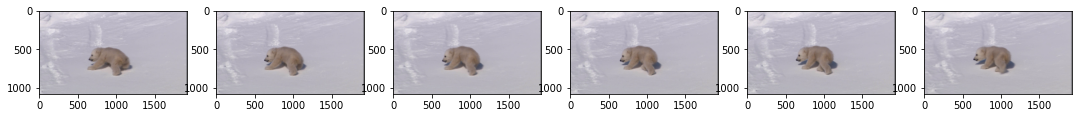

True direction: forwards
[[0.78400165 0.21599841]] Model prediction: backwards  with a 78.40016484260559% prediction


<Figure size 432x288 with 0 Axes>

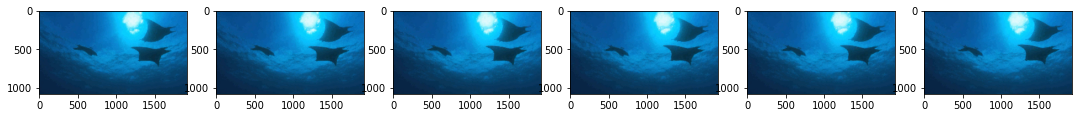

True direction: forwards
[[4.8938004e-33 1.0000000e+00]] Model prediction: forwards  with a 100.0% prediction


In [90]:
for i in tensor_trainning_dataset3.take(2):
    output=model.predict(i[0])
    plt.figure()
    f, axarr = plt.subplots(1,6)
    for index,image in enumerate(i[0]):
        axarr[index].imshow(tf.image.resize(i[0][index][0],(1080,1920),'nearest'))
#         axarr[index].imshow(i[0][index][0])
    f.set_size_inches(18.5, 10.5)
    plt.show()
    print("True direction:","forwards" if i[1][0]  else "backwards")
    print(output,"Model prediction:", "forwards" if np.argmax(output) else "backwards",f" with a {output[0][np.argmax(output)]*100}% prediction")
#         plt.imshow()
#     output[np.argmax(output,axis=1)]
#     forwards=np.argmax(output,axis=1)[::2]
#     backwards=np.argmax(output,axis=1)[1::2]

#     (len(forwards)-np.count_nonzero(forwards))
    
#     print(forwards==0) # Video going backwards output should be 0
#     print(backwards==1) # Video going forwards output should be 1
#     totalForwards+=np.count_nonzero(forwards==0)
#     totalBackwards+=np.count_nonzero(forwards==1)
#     forwardsDetections+=len(forwards)
#     backwardsDetections+=len(backwards)
#     print("forwards ",totalForwards/forwardsDetections)
#     print("backwards ",totalBackwards/backwardsDetections)
#     print("acc", (((totalForwards/forwardsDetections)+(totalBackwards/backwardsDetections))/2))

In [ ]:
correct=0
n=0
for i in tensor_trainning_dataset2:
    output=model.predict(i[0])
    n+=len(i[1])
    correct+=np.count_nonzero(np.argmax(output,axis=1)==i[1])
#     output=model.predict(i[0])
#     n+=1
#     if i[1][0] == np.argmax(output):
#         correct+=1
    print(correct/n)
    

0.5
0.575
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.54
0.5545454545454546
0.5083333333333333
0.5346153846153846
0.5321428571428571
0.5633333333333334
0.590625
0.6147058823529412
0.6333333333333333
0.6526315789473685
0.67
0.6738095238095239
0.6727272727272727
0.6847826086956522
0.6916666666666667
0.704
0.7134615384615385
0.6981481481481482
0.6982142857142857
0.6862068965517242
0.69
0.6838709677419355
0.6875
0.6848484848484848
0.6941176470588235
0.7028571428571428
0.6986111111111111
0.6986486486486486
0.7
0.6923076923076923
0.7
0.7048780487804878
0.7119047619047619
0.7058139534883721
0.6954545454545454
0.68
0.6652173913043479
0.6553191489361702
0.6427083333333333
0.636734693877551
0.643
0.6490196078431373
0.6528846153846154
0.6509433962264151
0.65
0.6454545454545455
0.6473214285714286
0.6447368421052632
0.6491379310344828
0.6516949152542373
0.6508333333333334
0.648360655737705
0.6459677419354839
0.6436507936507937
0.64140625
0.6392307692307693
0.6378787878787879
0.6358208955223881
0.6316176470588235

0.5956803455723542
0.5959051724137931
0.5965591397849462
0.5967811158798283
0.5965738758029978
0.5959401709401709
0.5946695095948827
0.5947872340425532
0.5947983014861996
0.5956567796610169
0.595983086680761
0.5955696202531645
0.5957894736842105
0.5960084033613445
0.5954926624737945
0.5963389121338912
0.5963465553235908
0.5966666666666667
0.5964656964656965
0.596058091286307
0.5953416149068324
0.5947314049586777
0.5947422680412371
0.5943415637860082
0.5937371663244353
0.5935450819672131
0.5939672801635992
0.5946938775510204
0.5954175152749491
0.5949186991869919
0.5949290060851927
0.5954453441295546
0.5958585858585859
0.5960685483870968
0.5955734406438632
0.5946787148594378
0.5954909819639278
0.5947
0.594311377245509
0.5950199203187251
0.5950298210735586
0.5953373015873016
0.5961386138613861
0.5969367588932807
0.5977317554240631
0.5985236220472441
0.5993123772102161
0.5995098039215686
0.600293542074364
0.60107421875
0.6018518518518519
0.6026264591439688
0.6030097087378641
0.603779069767

0.6222898230088496
0.6221546961325967
0.6224613686534216
0.6227673649393606
0.6226872246696036
0.6223872387238724
0.6223076923076923
0.6218990120746433
0.6222039473684211
0.6219058050383351
0.6212253829321663
0.6212021857923498
0.6215065502183406
0.6214285714285714
0.6211873638344226
0.620620239390642
0.6199456521739131
0.6195439739413681
0.6197396963123645
0.6196099674972915
0.6192099567099567
0.6194054054054055
0.6196004319654428
0.6193635382955771
0.6192887931034483
0.6192680301399354
0.6194623655913979
0.6193340494092374
0.6196351931330472
0.6199356913183279
0.620289079229122
0.6205347593582887
0.620940170940171
0.6213447171824973
0.6217484008528784
0.6221512247071352
0.6225531914893617
0.6229543039319873
0.623036093418259
0.6233297985153765
0.6237288135593221
0.624021164021164
0.6242600422832981
0.6239704329461457
0.6242088607594937
0.6242887249736565
0.6244736842105263
0.6248685594111462
0.6249474789915966
0.625183630640084
0.6255765199161426
0.6259685863874346
0.625836820083682


In [ ]:
n

In [ ]:
correct

In [84]:
model.save("back4ards2")

INFO:tensorflow:Assets written to: back4ards2/assets


In [85]:
!zip back4ards2.zip -r back4ards2

  adding: back4ards2/ (stored 0%)
  adding: back4ards2/variables/ (stored 0%)
  adding: back4ards2/variables/variables.index (deflated 73%)
  adding: back4ards2/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: back4ards2/saved_model.pb (deflated 91%)
  adding: back4ards2/assets/ (stored 0%)
  adding: back4ards2/keras_metadata.pb (deflated 95%)


In [86]:
!git add model2.ipynb back4ards2.zip

In [87]:
!git commit -m "auto"

[main b6e0d82] auto
 2 files changed, 86 insertions(+), 1282 deletions(-)
 create mode 100644 back4ards2.zip


In [88]:
!git push

Enumerating objects: 6, done.
Counting objects: 100% (6/6), done.
Delta compression using up to 8 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 24.36 MiB | 2.42 MiB/s, done.
Total 4 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
remote: 
remote: GitHub found 30 vulnerabilities on AsimPoptani/Backwards_Detection's default branch (2 critical, 14 high, 7 moderate, 7 low). To find out more, visit:
remote:      https://github.com/AsimPoptani/Backwards_Detection/security/dependabot
remote: 
To github.com:AsimPoptani/Backwards_Detection.git
   144a3d6..b6e0d82  main -> main


In [89]:
history2=model.fit(tensor_trainning_dataset2,epochs=600)

Epoch 1/600
1157/1157 [==============================] - 125s 108ms/step - loss: 0.0124 - binary_accuracy: 0.5000 - mean_squared_error: 0.4952 - sparse_categorical_accuracy: 0.9937
Epoch 2/600
1157/1157 [==============================] - 125s 108ms/step - loss: 0.0132 - binary_accuracy: 0.5000 - mean_squared_error: 0.4951 - sparse_categorical_accuracy: 0.9927
Epoch 3/600
 681/1157 [================>.............] - ETA: 51s - loss: 0.0200 - binary_accuracy: 0.5000 - mean_squared_error: 0.4924 - sparse_categorical_accuracy: 0.9883

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1157/1157 [==============================] - 125s 108ms/step - loss: 0.0142 - binary_accuracy: 0.5000 - mean_squared_error: 0.4951 - sparse_categorical_accuracy: 0.9921
Epoch 15/600
1157/1157 [==============================] - 124s 108ms/step - loss: 0.0135 - binary_accuracy: 0.5000 - mean_squared_error: 0.4953 - sparse_categorical_accuracy: 0.9923
Epoch 16/600
 990/1157 [========================>.....] - ETA: 17s - loss: 0.0116 - binary_accuracy: 0.5000 - mean_squared_error: 0.4955 - sparse_categorical_accuracy: 0.9928

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1157/1157 [==============================] - 125s 108ms/step - loss: 0.0120 - binary_accuracy: 0.5000 - mean_squared_error: 0.4961 - sparse_categorical_accuracy: 0.9929
Epoch 28/600
1157/1157 [==============================] - 125s 108ms/step - loss: 0.0106 - binary_accuracy: 0.5000 - mean_squared_error: 0.4961 - sparse_categorical_accuracy: 0.9933
Epoch 29/600
1157/1157 [==============================] - 124s 108ms/step - loss: 0.0091 - binary_accuracy: 0.5000 - mean_squared_error: 0.4967 - sparse_categorical_accuracy: 0.9948
Epoch 30/600
 231/1157 [====>.........................] - ETA: 1:39 - loss: 0.0379 - binary_accuracy: 0.5000 - mean_squared_error: 0.4857 - sparse_categorical_accuracy: 0.9740

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1157/1157 [==============================] - 125s 108ms/step - loss: 0.0095 - binary_accuracy: 0.5000 - mean_squared_error: 0.4963 - sparse_categorical_accuracy: 0.9936
Epoch 41/600
1157/1157 [==============================] - 125s 108ms/step - loss: 0.0109 - binary_accuracy: 0.5000 - mean_squared_error: 0.4962 - sparse_categorical_accuracy: 0.9942
Epoch 42/600
1157/1157 [==============================] - 125s 108ms/step - loss: 0.0095 - binary_accuracy: 0.5000 - mean_squared_error: 0.4963 - sparse_categorical_accuracy: 0.9940
Epoch 43/600
 571/1157 [=============>................] - ETA: 1:03 - loss: 0.0192 - binary_accuracy: 0.5000 - mean_squared_error: 0.4933 - sparse_categorical_accuracy: 0.9892

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1157/1157 [==============================] - 124s 108ms/step - loss: 0.0091 - binary_accuracy: 0.5000 - mean_squared_error: 0.4969 - sparse_categorical_accuracy: 0.9944
Epoch 55/600
1157/1157 [==============================] - 125s 108ms/step - loss: 0.0078 - binary_accuracy: 0.5000 - mean_squared_error: 0.4970 - sparse_categorical_accuracy: 0.9949
Epoch 56/600
1157/1157 [==============================] - 125s 108ms/step - loss: 0.0078 - binary_accuracy: 0.5000 - mean_squared_error: 0.4970 - sparse_categorical_accuracy: 0.9947
Epoch 57/600
 287/1157 [======>.......................] - ETA: 1:33 - loss: 0.0295 - binary_accuracy: 0.5000 - mean_squared_error: 0.4892 - sparse_categorical_accuracy: 0.9793

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1157/1157 [==============================] - 125s 108ms/step - loss: 0.0079 - binary_accuracy: 0.5000 - mean_squared_error: 0.4970 - sparse_categorical_accuracy: 0.9948
Epoch 69/600
1157/1157 [==============================] - 125s 108ms/step - loss: 0.0078 - binary_accuracy: 0.5000 - mean_squared_error: 0.4970 - sparse_categorical_accuracy: 0.9946
Epoch 70/600
 907/1157 [======================>.......] - ETA: 26s - loss: 0.0099 - binary_accuracy: 0.5000 - mean_squared_error: 0.4964 - sparse_categorical_accuracy: 0.9939

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1157/1157 [==============================] - 125s 108ms/step - loss: 0.0078 - binary_accuracy: 0.5000 - mean_squared_error: 0.4971 - sparse_categorical_accuracy: 0.9950
Epoch 82/600
1157/1157 [==============================] - 125s 108ms/step - loss: 0.0078 - binary_accuracy: 0.5000 - mean_squared_error: 0.4971 - sparse_categorical_accuracy: 0.9948
Epoch 83/600
1107/1157 [===========================>..] - ETA: 6s - loss: 0.0095 - binary_accuracy: 0.5000 - mean_squared_error: 0.4969 - sparse_categorical_accuracy: 0.9946

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1157/1157 [==============================] - 125s 108ms/step - loss: 0.0080 - binary_accuracy: 0.5000 - mean_squared_error: 0.4970 - sparse_categorical_accuracy: 0.9949
Epoch 95/600
1157/1157 [==============================] - 125s 108ms/step - loss: 0.0074 - binary_accuracy: 0.5000 - mean_squared_error: 0.4972 - sparse_categorical_accuracy: 0.9957
Epoch 96/600
1157/1157 [==============================] - 125s 108ms/step - loss: 0.0073 - binary_accuracy: 0.5000 - mean_squared_error: 0.4972 - sparse_categorical_accuracy: 0.9955
Epoch 97/600
 480/1157 [===========>..................] - ETA: 1:12 - loss: 0.0174 - binary_accuracy: 0.5000 - mean_squared_error: 0.4939 - sparse_categorical_accuracy: 0.9896

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1157/1157 [==============================] - 125s 108ms/step - loss: 0.0083 - binary_accuracy: 0.5000 - mean_squared_error: 0.4970 - sparse_categorical_accuracy: 0.9952
Epoch 109/600
1157/1157 [==============================] - 125s 108ms/step - loss: 0.0077 - binary_accuracy: 0.5000 - mean_squared_error: 0.4971 - sparse_categorical_accuracy: 0.9955
Epoch 110/600
1157/1157 [==============================] - 125s 108ms/step - loss: 0.0091 - binary_accuracy: 0.5000 - mean_squared_error: 0.4969 - sparse_categorical_accuracy: 0.9947
Epoch 111/600
  42/1157 [>.............................] - ETA: 1:59 - loss: 0.0343 - binary_accuracy: 0.5000 - mean_squared_error: 0.4977 - sparse_categorical_accuracy: 0.9869

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1157/1157 [==============================] - 125s 108ms/step - loss: 0.0073 - binary_accuracy: 0.5000 - mean_squared_error: 0.4972 - sparse_categorical_accuracy: 0.9955
Epoch 123/600
1157/1157 [==============================] - 125s 108ms/step - loss: 0.0072 - binary_accuracy: 0.5000 - mean_squared_error: 0.4975 - sparse_categorical_accuracy: 0.9955
Epoch 124/600
 957/1157 [=======================>......] - ETA: 21s - loss: 0.0086 - binary_accuracy: 0.5000 - mean_squared_error: 0.4968 - sparse_categorical_accuracy: 0.9946

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1157/1157 [==============================] - 125s 108ms/step - loss: 0.0085 - binary_accuracy: 0.5000 - mean_squared_error: 0.4969 - sparse_categorical_accuracy: 0.9948
Epoch 131/600
 762/1157 [==================>...........] - ETA: 42s - loss: 0.0113 - binary_accuracy: 0.5000 - mean_squared_error: 0.4957 - sparse_categorical_accuracy: 0.9930

KeyboardInterrupt: 